## Importing packages

In [1]:
from numba import cuda
cuda.select_device(0)
cuda.close()

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import cv2
#import pydicom

import os
import glob
import h5py
import shutil

#import imgaug as aug

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mimg
#import imgaug.augmenters as iaa
from os import listdir, makedirs, getcwd, remove
from os.path import isfile, join, abspath, exists, isdir, expanduser

from PIL import Image
from pathlib import Path
from skimage.io import imread
from skimage.transform import resize

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
#from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, SeparableConv2D, MaxPool2D, GlobalAveragePooling2D
from keras.layers import GlobalMaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import Concatenate
from keras.models import Model
from keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.utils import to_categorical
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions
from keras.applications.vgg16 import VGG16

import itertools

color = sns.color_palette()



Using TensorFlow backend.


In [2]:
## Reading data

In [3]:
# Define path to the data directory
data_dir = os.path.join('..', 'D:\Project\F10\Data Aug')
# test_dir ="C:\\Users\\Sumana\\Documents\\MATLAB\\Skin cancer\\Dataset\\test 2018"


In [6]:
# Set folder names as labels
akiec_cases = data_dir + '//' + 'akiec//*'
bcc_cases = data_dir + '//' + 'bcc//*'
bkl_cases = data_dir + '//' + 'bkl//*'
df_cases = data_dir + '//' + 'df//*'
mel_cases = data_dir + '//' + 'mel//*'
nv_cases = data_dir + '//' + 'nv//*'
vasc_cases = data_dir + '//' + 'vasc//*'


# Get the list of all the images
akiec_cases = glob.glob(akiec_cases)
bcc_cases = glob.glob(bcc_cases)
bkl_cases = glob.glob(bkl_cases)
df_cases = glob.glob(df_cases)
mel_cases = glob.glob(mel_cases)
nv_cases = glob.glob(nv_cases)
vasc_cases = glob.glob(vasc_cases)

#Set counter
#import random

# akiec_cases = random.sample(akiec_cases, 2000)

# bcc_cases = random.sample(bcc_cases, 2000)

# bkl_cases = random.sample(bkl_cases, 2000)

# df_cases = random.sample(df_cases, 2000)

# mel_cases = random.sample(mel_cases, 2000)

# nv_cases = random.sample(nv_cases, 2000)

# vasc_cases = random.sample(vasc_cases, 2000)



In [7]:
# Get the counts for each class
cases_count = train_data['label'].value_counts()
print(cases_count)

# Plot the results 
plt.figure(figsize=(20,10))
sns.barplot(x=cases_count.index, y= cases_count.values)
plt.title('Number of cases', fontsize=14)
plt.xlabel('Case type', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(range(len(cases_count.index)), ['MEL', 'NV','BCC','AKIEC','BKL','DF','VASC'], fontsize=20)
plt.show()

NameError: name 'train_data' is not defined

## Preparing train, test and val data

# Train data

In [7]:
# List that are going to contain validation images data and the corresponding labels
train_data = []
train_label = []


# Some images are in grayscale while majority of them contains 3 channels. So, if the image is grayscale, we will convert into a image with 3 channels.
# We will normalize the pixel values and resizing all the images to 224x224

# All Cases
cases = [akiec_cases, bcc_cases, bkl_cases, df_cases, mel_cases, nv_cases, vasc_cases]
for case_num in range(7):
    for img in cases[case_num]:
        img = cv2.imread(str(img))
        img = cv2.resize(img, (224,224))
#         img = img.astype(np.float32)/255.
        label = to_categorical(case_num, num_classes=7)
        train_data.append(img)
        train_label.append(label)

# Convert the list into numpy arrays
train_data = np.array(train_data)
train_label = np.array(train_label)

print("Total number of examples: ", train_data.shape)
print("Total number of labels:", train_label.shape)


Total number of examples:  (20871, 224, 224, 3)
Total number of labels: (20871, 7)


In [8]:
# Split dataset into train, test and validate
from sklearn.model_selection import train_test_split
data_train, data_val, label_train, label_val = train_test_split(train_data, train_label, test_size=0.20,shuffle=True)
number_of_train = data_train.shape[0]
number_of_test = data_val.shape[0]
print('Train', number_of_train)
print('Validate',number_of_test)

# from sklearn.model_selection import train_test_split
# data1_train, data_val, label1_train, label_val = train_test_split(data_train, label_train, test_size=0.20, random_state=42)
# number_of_train = data1_train.shape[0]
# number_of_validate = data_val.shape[0]
# print('Train', number_of_train)
# print('Validate',number_of_test)

Train 20871
Validate 4175


## Defining a basic CNN Model

In [9]:
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils, to_categorical
from keras.utils.data_utils import get_file
from keras.callbacks import Callback
from keras.applications.imagenet_utils import preprocess_input
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from keras.initializers import glorot_uniform
import scipy.misc
from matplotlib.pyplot import imshow
import keras.backend as K
K.set_image_data_format('channels_last')
K.set_learning_phase(1)

%matplotlib inline 
#plotting directly without requering the plot()

import warnings
warnings.filterwarnings(action="ignore") #ignoring most of warnings, cleaning up the notebook for better visualization

pd.set_option('display.max_columns', 500) #fixing the number of rows and columns to be displayed
pd.set_option('display.max_rows', 500)


In [10]:
#identity_block

def identity_block(X, f, filters, stage, block):
    """
    Implementation of the identity block as defined in Figure 3
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    
    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value. You'll need this later to add back to the main path. 
    X_shortcut = X
    
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    # Second component of main path
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X,X_shortcut])
    X = Activation('relu')(X)
    
    return X

In [11]:
#convolutional_block

def convolutional_block(X, f, filters, stage, block, s = 2):
    """
    Implementation of the convolutional block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    s -- Integer, specifying the stride to be used
    
    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X


    ##### MAIN PATH #####
    # First component of main path 
    X = Conv2D(F1, (1, 1), strides = (s,s), name = conv_name_base + '2a',padding = 'valid', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    # Second component of main path
    X = Conv2D(F2, (f, f), strides = (1,1), name = conv_name_base + '2b', padding = 'same', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path
    X = Conv2D(F3, (1, 1), strides = (1,1), name = conv_name_base + '2c', padding = 'valid', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    ##### SHORTCUT PATH ####
    X_shortcut = Conv2D(F3, (1, 1), strides = (s,s), name = conv_name_base + '1', padding = 'valid', kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X,X_shortcut])
    X = Activation('relu')(X)
    
    return X

In [12]:
def ResNet50(input_shape=(224, 224, 3), classes=6):
    """
    Implementation of the popular ResNet50 the following architecture:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> TOPLAYER

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """

    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)

    # Stage 1
    X = Conv2D(64, (7, 7), strides=(2, 2), name='conv1', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name='bn_conv1')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)
    X = Activation('relu')(X)
   

    # Stage 2
    X = convolutional_block(X, f=3, filters=[64, 64, 256], stage=2, block='a', s=1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')

    ### START CODE HERE ###

    # Stage 3 (≈4 lines)
    X = convolutional_block(X, f = 3, filters = [128, 128, 512], stage = 3, block='a', s = 2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    # Stage 4 (≈6 lines)
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], stage = 4, block='a', s = 2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    # Stage 5 (≈3 lines)
    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], stage = 5, block='a', s = 2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    # AVGPOOL (≈1 line). Use "X = AveragePooling2D(...)(X)"
    X = AveragePooling2D((7,7), name="avg_pool")(X)

    ### END CODE HERE ###

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)
    
    
    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model

In [13]:
model = ResNet50(input_shape = (224, 224, 3), classes = 7)

In [14]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "ResNet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
___________________________________________________________________________________________

### Defining Callbacks

In [27]:
#Reduce learning rate on plateau
# es = EarlyStopping(monitor='val_loss',verbose=1, restore_best_weights=True, patience=2)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=3,
                                            mode='auto',
                                            verbose=1, 
                                            factor=0.2, 
                                            min_lr=0.01)

### Fit/Train Model

In [28]:
y_train_labels = np.argmax(label_train, axis =1)

from sklearn.utils import class_weight
class_weight = class_weight.compute_class_weight('balanced' ,np.unique(y_train_labels) ,y_train_labels)
num_epochs =20
batch_size = 32
history = model.fit(data_train,label_train,
                    batch_size=batch_size,
                    shuffle = True,
                    epochs=num_epochs,
                    validation_data = (data_val, label_val),
                    verbose=1,
                    class_weight=class_weight,
                    callbacks = [learning_rate_reduction])

Train on 16696 samples, validate on 4175 samples
Epoch 1/20
16696/16696 [==============================] - 298s 18ms/step - loss: 0.4817 - accuracy: 0.8164 - val_loss: 0.6955 - val_accuracy: 0.7526
Epoch 2/20
16696/16696 [==============================] - 300s 18ms/step - loss: 0.4012 - accuracy: 0.8519 - val_loss: 0.6675 - val_accuracy: 0.7758
Epoch 3/20
16696/16696 [==============================] - 301s 18ms/step - loss: 0.3339 - accuracy: 0.8790 - val_loss: 0.7089 - val_accuracy: 0.7617
Epoch 4/20
16696/16696 [==============================] - 301s 18ms/step - loss: 0.2688 - accuracy: 0.9007 - val_loss: 0.6587 - val_accuracy: 0.7969
Epoch 5/20
16696/16696 [==============================] - 301s 18ms/step - loss: 0.2149 - accuracy: 0.9225 - val_loss: 0.6316 - val_accuracy: 0.8125
Epoch 6/20
16696/16696 [==============================] - 301s 18ms/step - loss: 0.1611 - accuracy: 0.9423 - val_loss: 0.7258 - val_accuracy: 0.8156
Epoch 7/20
16696/16696 [==============================] -

In [17]:
# #Using Generator
# from sklearn.utils import class_weight
# class_weight = class_weight.compute_class_weight('balanced' ,np.unique(label_train) ,label_train)
# datagen.fit(data_train)
# history = model.fit_generator(datagen.flow(data_train, label_train, batch_size=64),epochs = 20, 
#                                    validation_data = (data_val,label_val),verbose = 2,
#                                    class_weight=class_weight
#                                    steps_per_epoch=train_data.shape[0]//32
#                                    , callbacks=[learning_rate_reduction], )
# #class_weight={0:1.0, 1:0.5})

### Loss/Acc Graph

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


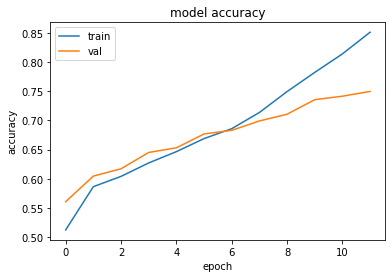

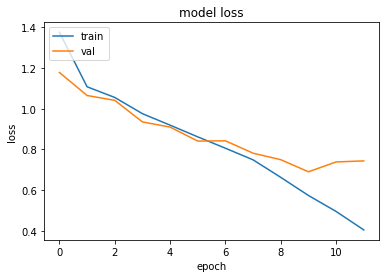

In [18]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Confusion Matrix

In [19]:
test_dir ="D:\\test 10\\*"

# Get the list of all the images
test_cases = glob.glob(test_dir)

# List that are going to contain validation images data and the corresponding labels
test_data = []
test_Tag_data=[]

# Some images are in grayscale while majority of them contains 3 channels. So, if the image is grayscale, we will convert into a image with 3 channels.
# We will normalize the pixel values and resizing all the images to 224x224

# Normal cases
for img in test_cases:
    imgTag = img.replace('D:\\test 10\\', '')
    imgTag= imgTag.replace('.jpg', '')
#     print(imgTag)
    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224))
    test_data.append(img)
    test_Tag_data.append(imgTag)
                      

# Convert the list into numpy arrays
test_data = np.array(test_data)



print("Total number of test examples: ", test_data.shape)

Total number of test examples:  (1512, 224, 224, 3)


In [20]:
pred=[]
# Predict the values from the validation dataset
Y_pred = model.predict(test_data)
# # Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred, axis = 1) 
print(Y_pred)
print(Y_pred.shape)
print(Y_pred_classes)
print(Y_pred_classes.shape)

test_Tag_data = np.array(test_Tag_data)
print(test_Tag_data)
print(test_Tag_data.shape)

def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / np.sum(e_x, axis=1, keepdims=True)

y_prob = softmax(Y_pred)

import pandas as pd 

pred=np.hstack((y_prob,test_Tag_data[:, None]) )
pd.DataFrame(data=pred, columns=["AKIEC","BCC","BKL","DF","MEL","NV","VASC", "image"]).to_csv("D:\\results\Filetest102.csv", index=False)

[[1.6344616e-02 1.6584338e-01 6.4851753e-02 ... 1.6251436e-01
  1.3981296e-01 6.0011924e-04]
 [2.8708372e-03 1.6028553e-01 2.6310539e-02 ... 4.7319335e-01
  2.9891536e-01 3.3625260e-03]
 [1.7846490e-01 6.8477809e-01 5.7665139e-02 ... 5.3089831e-02
  3.3039509e-03 5.4765708e-04]
 ...
 [1.7477527e-01 5.3827059e-02 6.0479856e-01 ... 1.3500533e-01
  2.9430699e-02 2.3428351e-05]
 [3.5367403e-02 3.2129072e-02 6.6689268e-02 ... 1.6002066e-01
  4.2116931e-01 9.9496238e-02]
 [9.3227816e-01 5.6427952e-02 1.3533405e-07 ... 1.0014787e-06
  4.3071601e-08 1.1242359e-02]]
(1512, 7)
[3 4 1 ... 2 5 0]
(1512,)
['ISIC_0034524' 'ISIC_0034525' 'ISIC_0034526' ... 'ISIC_0036062'
 'ISIC_0036063' 'ISIC_0036064']
(1512,)


In [21]:
# # Look at confusion matrix 
# #Note, this code is taken straight from the SKLEARN website, an nice way of viewing confusion matrix.
# def plot_confusion_matrix(cm, classes,
#                           normalize=False,
#                           title='Confusion matrix',
#                           cmap=plt.cm.Blues):
#     """
#     This function prints and plots the confusion matrix.
#     Normalization can be applied by setting `normalize=True`.
#     """
#     plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.title(title)
#     plt.colorbar()
#     tick_marks = np.arange(len(classes))
#     plt.xticks(tick_marks, classes, rotation=45)
#     plt.yticks(tick_marks, classes)

#     if normalize:
#         cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

#     thresh = cm.max() / 2.
#     for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
#         plt.text(j, i, cm[i, j],
#                  horizontalalignment="center",
#                  color="white" if cm[i, j] > thresh else "black")

#     plt.tight_layout()
#     plt.ylabel('True label')
#     plt.xlabel('Predicted label')

# # Predict the values from the validation dataset
# Y_pred = model.predict(data_test)
# # Convert predictions classes to one hot vectors 
# Y_pred_classes = np.argmax(Y_pred, axis = 1) 
# # Convert validation observations to one hot vectors
# Y_true = np.argmax(label_test, axis = 1) 
# # compute the confusion matrix
# cm = confusion_matrix(Y_true, Y_pred_classes) 
# # plot the confusion matrix
# plot_confusion_matrix(cm, classes = range(7))
# # Find accuracy
# from sklearn import metrics
# print("Overall Accuracy: ", metrics.accuracy_score(Y_true, Y_pred_classes))
# from sklearn.metrics import classification_report
# from sklearn.metrics import recall_score
# from sklearn.metrics import f1_score
# print(classification_report(Y_true, Y_pred_classes, labels=[0,1, 2, 3, 4, 5, 6]))
# print("Overall sensitivity:",recall_score(Y_true, Y_pred_classes, average='micro'))
# print("Overall Fscore:" , f1_score(Y_true, Y_pred_classes, average='micro'))


# FP = cm.sum(axis=0) - np.diag(cm)  
# print(FP)
# FN = cm.sum(axis=1) - np.diag(cm)
# print(FN)
# TP = np.diag(cm)
# print(TP)
# TN = cm.sum() - (FP + FN + TP)
# print(TN)

# FP = FP.astype(float)
# FN = FN.astype(float)
# TP = TP.astype(float)
# TN = TN.astype(float)

# # Sensitivity, hit rate, recall, or true positive rate
# TPR = TP/(TP+FN)
# print("Sensitivity: ", TPR)
# # Specificity or true negative rate
# TNR = TN/(TN+FP) 
# print("Specificty: ", TNR)
# print("Overall SPecificity=", np.mean(TNR))
# # Precision or positive predictive value
# PPV = TP/(TP+FP)
# print("Precision: ", PPV)
# rec= TP/(TP+FN)
# print("Recall: ", rec)
# #F-score
# fs=(2*PPV*rec)/(PPV+rec)
# print("F-score: ", fs)
# # Negative predictive value
# NPV = TN/(TN+FN)
# # Fall out or false positive rate
# FPR = FP/(FP+TN)
# # False negative rate
# FNR = FN/(TP+FN)
# # False discovery rate
# FDR = FP/(TP+FP)
# # #Auc curve
# # from sklearn.metrics import roc_auc_score
# # roc_auc_score(Y_true, Y_pred,multi_class='ovo')
# # Overall accuracy
# ACC = (TP+TN)/(TP+FP+FN+TN)
# print("Classwise acc: ", ACC)


## Save and load model

In [22]:
'''# serialize model to JSON
model_json = cnnmodel1.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("cnnmodel1_model.h5")
print("Saved model to disk")'''
 
 
'''# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")'''

'# load json and create model\njson_file = open(\'model.json\', \'r\')\nloaded_model_json = json_file.read()\njson_file.close()\nloaded_model = model_from_json(loaded_model_json)\n# load weights into new model\nloaded_model.load_weights("model.h5")\nprint("Loaded model from disk")'

## Reading sample test image

In [23]:
# from keras.preprocessing import image

# img_path = 'F://documents//ground truth//microcalcification//2448243.jpg'
# img = image.load_img(img_path, target_size=(224, 224))
# img_tensor = image.img_to_array(img)
# img_tensor = np.expand_dims(img_tensor, axis=0)
# img_tensor /= 255.
# plt.imshow(img_tensor[0])
# plt.show()
# print(img_tensor.shape)

In [24]:
# # predicting images
# x = image.img_to_array(img)
# x = np.expand_dims(x, axis=0)
# images = np.vstack([x])
# classes = cnnmodel1.predict(images, batch_size=32)
# classes = classes.argmax(axis=-1)
# print("Predicted class is:",classes)